## 0. data

In [1]:
from dataset import MyDataset
from argparse import Namespace
from torchvision import transforms

# Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
bs1 = 24
bs2 = 1

train_dir = "imgs/train/"
train_dataset_ = MyDataset(train_dir, transform=transform)
print(f'Number of training samples: {len(train_dataset_)}')

test1_dir = "imgs/internal/"
test_dataset1 = MyDataset(test1_dir, transform=transform)
print(f'Number of internal testing samples: {len(test_dataset1)}')

test2_dir = "imgs/external1/"
test_dataset2 = MyDataset(test2_dir, transform=transform)
print(f'Number of external1 testing samples: {len(test_dataset2)}')

test3_dir = "imgs/external2/"
test_dataset3 = MyDataset(test3_dir, transform=transform)
print(f'Number of external2 testing samples: {len(test_dataset3)}')

Number of training samples: 2736
Number of internal testing samples: 241
Number of external1 testing samples: 303
Number of external2 testing samples: 215


In [2]:
from torch.utils.data import DataLoader, Subset

train_indices = list(range(0, int(len(train_dataset_) * 0.8)))
val_indices = list(range(int(len(train_dataset_) * 0.8), len(train_dataset_)))

train_dataset, val_dataset = Subset(train_dataset_, train_indices), Subset(train_dataset_, val_indices)
train_dataloader, val_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True), DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=True)

print(len(train_dataset), len(val_dataset))
print(len(train_dataloader), len(val_dataloader))

# --------------------------------

test_dataloader1 = DataLoader(test_dataset1, batch_size=1, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=1, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=1, shuffle=False)

print(len(test_dataset1), len(test_dataset2), len(test_dataset3))
print(len(test_dataloader1), len(test_dataloader2), len(test_dataloader3))

2188 548
547 137
241 303 215
241 303 215


In [3]:
for i, batch in enumerate(train_dataloader):
    print(batch['T1'].shape, batch['T1c'].shape, batch['T2'].shape)
    break

for i, batch in enumerate(test_dataloader1):
    print(batch['T1'].shape, batch['T1c'].shape, batch['T2'].shape)
    break

for i, batch in enumerate(test_dataloader2):
    print(batch['T1'].shape, batch['T1c'].shape, batch['T2'].shape)
    break

for i, batch in enumerate(test_dataloader3):
    print(batch['T1'].shape, batch['T1c'].shape, batch['T2'].shape)
    break


torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224]) torch.Size([4, 1, 224, 224])
torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224]) torch.Size([1, 1, 224, 224])


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. CLIP

In [5]:
import torch
from transformers import CLIPModel, CLIPTokenizer

clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

text_data = [
    'T1-weighted (T1) images provide high-resolution anatomical detail, with fat appearing bright and water appearing dark, useful for visualizing normal tissue structure.',
    'T1 contrast-enhanced (T1c) images involve the administration of a contrast agent, enhancing vascular structures and providing better visualization of tumors and lesions.',
    'T2-weighted (T2) images emphasize fluid-rich tissues, with water appearing bright and fat darker, making it ideal for detecting abnormalities like edema or inflammation.',
    'T2 Fluid-Attenuated Inversion Recovery MRI (FLAIR) suppresses cerebrospinal fluid (CSF) signals to better visualize pathological tissues with high water content, such as edema, tumors, or white matter lesions.',
    'Proton density (PD) weighted MRI image highlights tissues with high hydrogen atom concentration, appearing brightest in areas like fat and fluid, while minimizing T1/T2 relaxation effects for enhanced tissue contrast.',
    'Magnetic Resonance Angiography (MRA) non-invasively images blood vessels by detecting flowing blood signals, aiding in diagnosing vascular abnormalities like stenosis, aneurysms, or malformations.',
]

text_inputs = tokenizer(text_data, padding=True, return_tensors="pt", truncation=True, max_length=77)
print("Text inputs shape:", text_inputs.input_ids.shape)
# print("Text inputs:", text_inputs.input_ids)

text_outputs = clipmodel.get_text_features(input_ids=text_inputs.input_ids)
print("Text features shape:", text_outputs.shape)
# print("Text features:", text_outputs)

Text inputs shape: torch.Size([6, 51])
Text features shape: torch.Size([6, 512])


In [6]:
labels = torch.tensor(list(range(len(text_data))))
labels

tensor([0, 1, 2, 3, 4, 5])

In [7]:
clipmodel = clipmodel.to('cuda')
text_inputs = text_inputs.to('cuda')
labels = torch.tensor(list(range(len(text_data)))).to('cuda')

### 1.1 just test default CLIP

In [8]:
outputs = clipmodel.get_text_features(input_ids=text_inputs.input_ids) # [6, 512]
predictions = outputs.argmax(dim=-1)
accuracy = (predictions == labels).float().mean()
print("Accuracy:", accuracy)

Accuracy: tensor(0., device='cuda:0')


In [9]:
# 测试集图片准确率

def test_acc(dataloaderi):
    acc, total = 0, 0

    for i, batch in enumerate(dataloaderi):
        # print(batch['T1'].shape, batch['T1c'].shape, batch['T2'].shape)
        
        # data1: concatenate all modalities in the batch dimension
        t1 = batch["T1"].to(device)   # [bs, ch, h, w]
        t1c = batch["T1c"].to(device)
        t2 = batch["T2"].to(device)
        all_images = torch.stack([t1, t1c, t2]) # [mod, bs, ch, h, w]
        all_images = all_images.permute(1, 0, 2, 3, 4).contiguous().view(-1, *all_images.shape[2:]) # [bs*mod, ch, h, w]
        bs = t1.shape[0]

        # data2: descriptions [[bs], ...] -> [bs * modalities]
        descriptions = text_data[:3] * bs
        all_descriptions = tokenizer(descriptions, padding=True, return_tensors="pt", truncation=True, max_length=77)

        # data3: labels [[bs], ...] -> [bs * modalities]
        all_labels = [0, 1, 2] * bs
        all_labels = torch.tensor(all_labels) # [bs * modalities]

        all_images = all_images.to('cuda')
        all_descriptions = all_descriptions.to('cuda')
        all_labels = all_labels.to('cuda')

        if all_images.shape[1] == 1:
            all_images = all_images.repeat(1, 3, 1, 1)  # [bs * n_modalities, 3, 224, 224]

        # 计算输出的准确率
        outputs = clipmodel.get_image_features(pixel_values=all_images) # [bs * modalities, 512] = [4 * 3, 512]
        predictions = outputs.argmax(dim=-1)
        acc += (predictions == all_labels).float().sum().item()
        total += all_labels.numel()

        print(i, (predictions == all_labels).float().sum().item())

    print("Accuracy:", acc / total)

In [10]:
# 内部测试集
test_acc(test_dataloader1)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [11]:
# 外部测试集1图片准确率
test_acc(test_dataloader2)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

In [12]:
# 外部测试集2图片准确率
test_acc(test_dataloader3)

0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 0.0
101 0.0
102 0.0
103 0.0
104 0.0
105 0.0
106 0.0
107 0.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 0.0
116 0.0
117 0.0
118 0.0
119 0.0
120 0.0
121 0.0
122 0.0
123 0.0
124 0.0
125 0.0
126 0.0
127 0.0
128 0.0
129 0.0
130 0.0
131 0.0
132 0.0
133 0.0
134 0.0
135 0.0
136 0.0
137 0.0
138 0.

### 1.2 align text to labels

Training CLIP Model: 100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]


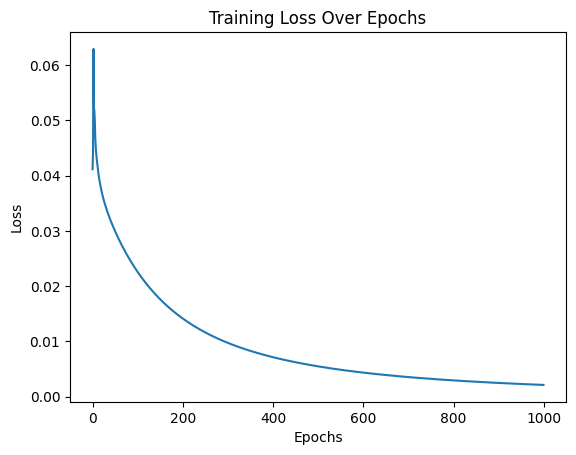

In [15]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

losses = []
clipmodel = clipmodel.to('cuda')
text_inputs = text_inputs.to('cuda')
labels = torch.tensor(list(range(len(text_data)))).to('cuda')

# training loop code
def train_text_loop(model, text_inputs, labels, epochs=1):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    tqdmm = tqdm(range(epochs), desc="Training CLIP Model")
    for epoch in tqdmm:
        model.train()
        outputs = model.get_text_features(input_ids=text_inputs.input_ids)
        loss = F.cross_entropy(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # save the model
    torch.save(model.state_dict(), "logs/clip_model_txt.pth")

# Example usage
train_text_loop(clipmodel, text_inputs, labels, epochs=1000)

# plot the losses
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [13]:
# test text & label alignment
# 计算输出的准确率
state_dict = torch.load("logs/clip_model_txt.pth", map_location="cpu", weights_only=True)
clipmodel.load_state_dict(state_dict)
clipmodel = clipmodel.to("cuda")
outputs = clipmodel.get_text_features(input_ids=text_inputs.input_ids) # [6, 512]
predictions = outputs.argmax(dim=-1)
accuracy = (predictions == labels).float().mean()
print("Accuracy:", accuracy)

Accuracy: tensor(1., device='cuda:0')


### 1.3 align images to labels

Epoch 1/5 [Train]: 100%|██████████| 547/547 [00:21<00:00, 24.87it/s, loss=0.0197]


Epoch 1: Train Loss = 0.2315, Val Loss = 0.4922


Epoch 2/5 [Train]: 100%|██████████| 547/547 [00:19<00:00, 28.40it/s, loss=0.00843]


Epoch 2: Train Loss = 0.0236, Val Loss = 0.0487


Epoch 3/5 [Train]: 100%|██████████| 547/547 [00:22<00:00, 24.75it/s, loss=0.00482]


Epoch 3: Train Loss = 0.0065, Val Loss = 0.0880


Epoch 4/5 [Train]: 100%|██████████| 547/547 [00:19<00:00, 28.39it/s, loss=0.00292]


Epoch 4: Train Loss = 0.0046, Val Loss = 0.0751


Epoch 5/5 [Train]: 100%|██████████| 547/547 [00:19<00:00, 28.33it/s, loss=0.00193]


Epoch 5: Train Loss = 0.0024, Val Loss = 0.1020


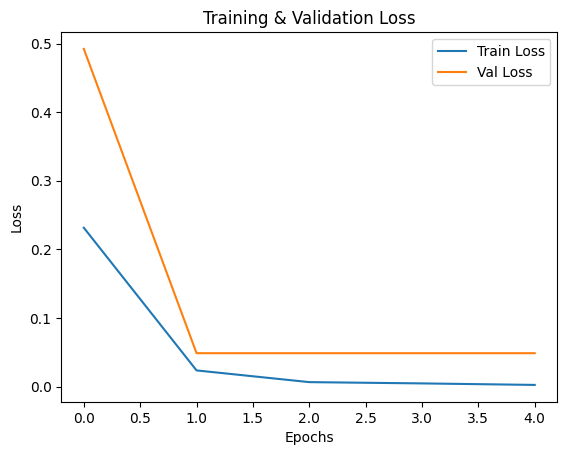

In [17]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clipmodel.load_state_dict(torch.load("logs/clip_model_txt.pth", map_location="cpu", weights_only=True))
optimizer = torch.optim.Adam(clipmodel.parameters(), lr=1e-5)
# 固定文本编码器
for param in clipmodel.text_model.parameters():
    param.requires_grad = False


def process_batch(batch, device="cuda"):

    # data1: concatenate all modalities in the batch dimension
    t1 = batch["T1"].to(device)   # [bs, ch, h, w]
    t1c = batch["T1c"].to(device)
    t2 = batch["T2"].to(device)
    all_images = torch.stack([t1, t1c, t2]) # [mod, bs, ch, h, w]
    all_images = all_images.permute(1, 0, 2, 3, 4).contiguous().view(-1, *all_images.shape[2:]) # [bs*mod, ch, h, w]
    bs = t1.shape[0]

    # data2: descriptions [[bs], ...] -> [bs * modalities]
    descriptions = text_data[:3] * bs
    all_descriptions = tokenizer(descriptions, padding=True, return_tensors="pt", truncation=True, max_length=77)

    # data3: labels [[bs], ...] -> [bs * modalities]
    all_labels = [0, 1, 2] * bs
    all_labels = torch.tensor(all_labels) # [bs * modalities]

    # move to device
    all_images = all_images.to(device)
    all_descriptions = all_descriptions.to(device)
    all_labels = all_labels.to(device)

    # expand grayscale to 3 channels if needed
    if all_images.shape[1] == 1:
        all_images = all_images.repeat(1, 3, 1, 1)

    return all_images, all_descriptions, all_labels


def train_loop(model, train_dataloader, val_dataloader, optimizer, epochs=1, device="cuda"):
    model = model.to(device)
    train_losses, val_losses, min_val_losses = [], [], []
    min_val_loss = float('inf')

    for epoch in range(epochs):
        # ----------------- Training -----------------
        model.train()
        tqdmm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        epoch_train_losses = []

        for batch in tqdmm:
            all_images, _, all_labels = process_batch(batch, device)
            outputs = model.get_image_features(pixel_values=all_images)
            loss = F.cross_entropy(outputs, all_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_losses.append(loss.item())
            tqdmm.set_postfix(loss=loss.item())

        mean_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_losses.append(mean_train_loss)

        # ----------------- Validation -----------------
        model.eval()
        epoch_val_losses = []
        with torch.no_grad():
            for batch in val_dataloader:
                all_images, _, all_labels = process_batch(batch, device)

                outputs = model.get_image_features(pixel_values=all_images)
                loss = F.cross_entropy(outputs, all_labels)
                epoch_val_losses.append(loss.item())

        mean_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        val_losses.append(mean_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {mean_train_loss:.4f}, Val Loss = {mean_val_loss:.4f}")

        # Save the model
        if mean_val_loss < min_val_loss:
            min_val_loss = mean_val_loss
            torch.save(model.state_dict(), "logs/clip_model_img.pth")
        min_val_losses.append(min_val_loss)
        
    return train_losses, val_losses, min_val_losses


# 调用
train_losses, val_losses, min_val_losses = train_loop(clipmodel, train_dataloader, val_dataloader, optimizer, epochs=5)

# 画图
plt.plot(train_losses, label="Train Loss")
plt.plot(min_val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [14]:
clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# 加载保存的权重
state_dict = torch.load("logs/clip_model_img.pth", map_location="cpu", weights_only=True)
clipmodel.load_state_dict(state_dict)
clipmodel = clipmodel.to("cuda")

In [15]:
test_acc(test_dataloader1)

0 2.0
1 2.0
2 2.0
3 2.0
4 2.0
5 2.0
6 2.0
7 3.0
8 3.0
9 3.0
10 3.0
11 3.0
12 3.0
13 3.0
14 2.0
15 2.0
16 2.0
17 2.0
18 2.0
19 3.0
20 2.0
21 2.0
22 3.0
23 3.0
24 3.0
25 3.0
26 3.0
27 3.0
28 3.0
29 3.0
30 3.0
31 3.0
32 3.0
33 3.0
34 3.0
35 3.0
36 3.0
37 3.0
38 3.0
39 3.0
40 3.0
41 3.0
42 3.0
43 3.0
44 3.0
45 3.0
46 3.0
47 3.0
48 3.0
49 3.0
50 3.0
51 3.0
52 3.0
53 3.0
54 3.0
55 3.0
56 3.0
57 3.0
58 3.0
59 3.0
60 3.0
61 3.0
62 3.0
63 3.0
64 3.0
65 3.0
66 3.0
67 3.0
68 3.0
69 3.0
70 3.0
71 3.0
72 3.0
73 3.0
74 3.0
75 3.0
76 3.0
77 3.0
78 3.0
79 3.0
80 3.0
81 3.0
82 3.0
83 3.0
84 3.0
85 3.0
86 3.0
87 3.0
88 3.0
89 3.0
90 3.0
91 3.0
92 3.0
93 3.0
94 3.0
95 3.0
96 3.0
97 3.0
98 3.0
99 3.0
100 3.0
101 3.0
102 3.0
103 3.0
104 3.0
105 3.0
106 3.0
107 3.0
108 3.0
109 3.0
110 3.0
111 3.0
112 3.0
113 3.0
114 3.0
115 3.0
116 3.0
117 3.0
118 3.0
119 3.0
120 3.0
121 3.0
122 3.0
123 3.0
124 3.0
125 3.0
126 3.0
127 3.0
128 3.0
129 3.0
130 3.0
131 3.0
132 3.0
133 3.0
134 3.0
135 3.0
136 3.0
137 3.0
138 3.

In [16]:
# 外部测试集1图片准确率
test_acc(test_dataloader2)

0 3.0
1 3.0
2 3.0
3 3.0
4 3.0
5 3.0
6 3.0
7 3.0
8 3.0
9 3.0
10 3.0
11 3.0
12 3.0
13 3.0
14 3.0
15 3.0
16 3.0
17 3.0
18 3.0
19 3.0
20 3.0
21 3.0
22 3.0
23 3.0
24 3.0
25 3.0
26 3.0
27 3.0
28 3.0
29 3.0
30 3.0
31 3.0
32 3.0
33 3.0
34 3.0
35 3.0
36 3.0
37 3.0
38 3.0
39 3.0
40 3.0
41 3.0
42 3.0
43 3.0
44 3.0
45 3.0
46 3.0
47 3.0
48 3.0
49 3.0
50 3.0
51 3.0
52 3.0
53 3.0
54 3.0
55 3.0
56 3.0
57 3.0
58 3.0
59 3.0
60 3.0
61 3.0
62 3.0
63 3.0
64 3.0
65 3.0
66 3.0
67 3.0
68 3.0
69 3.0
70 3.0
71 3.0
72 3.0
73 3.0
74 3.0
75 3.0
76 2.0
77 3.0
78 3.0
79 3.0
80 3.0
81 3.0
82 3.0
83 3.0
84 3.0
85 3.0
86 3.0
87 3.0
88 3.0
89 3.0
90 3.0
91 3.0
92 3.0
93 3.0
94 3.0
95 3.0
96 3.0
97 3.0
98 3.0
99 3.0
100 3.0
101 3.0
102 3.0
103 3.0
104 3.0
105 3.0
106 3.0
107 3.0
108 3.0
109 3.0
110 3.0
111 3.0
112 3.0
113 3.0
114 3.0
115 3.0
116 3.0
117 3.0
118 3.0
119 3.0
120 3.0
121 3.0
122 3.0
123 3.0
124 3.0
125 3.0
126 2.0
127 3.0
128 3.0
129 3.0
130 3.0
131 3.0
132 3.0
133 3.0
134 3.0
135 3.0
136 3.0
137 3.0
138 3.

In [17]:
# 外部测试集2图片准确率
test_acc(test_dataloader3)

0 3.0
1 3.0
2 3.0
3 3.0
4 3.0
5 3.0
6 3.0
7 3.0
8 3.0
9 3.0
10 3.0
11 3.0
12 3.0
13 3.0
14 3.0
15 3.0
16 3.0
17 3.0
18 3.0
19 3.0
20 3.0
21 3.0
22 3.0
23 3.0
24 3.0
25 3.0
26 3.0
27 3.0
28 3.0
29 3.0
30 3.0
31 3.0
32 3.0
33 3.0
34 3.0
35 3.0
36 3.0
37 3.0
38 3.0
39 3.0
40 3.0
41 3.0
42 3.0
43 3.0
44 3.0
45 3.0
46 3.0
47 3.0
48 3.0
49 3.0
50 3.0
51 3.0
52 3.0
53 3.0
54 3.0
55 3.0
56 3.0
57 3.0
58 3.0
59 3.0
60 3.0
61 3.0
62 3.0
63 3.0
64 3.0
65 3.0
66 3.0
67 3.0
68 3.0
69 3.0
70 3.0
71 3.0
72 3.0
73 3.0
74 3.0
75 3.0
76 3.0
77 3.0
78 3.0
79 3.0
80 3.0
81 3.0
82 3.0
83 3.0
84 3.0
85 3.0
86 3.0
87 3.0
88 3.0
89 3.0
90 3.0
91 3.0
92 3.0
93 3.0
94 3.0
95 3.0
96 3.0
97 3.0
98 3.0
99 3.0
100 3.0
101 3.0
102 3.0
103 3.0
104 3.0
105 3.0
106 3.0
107 3.0
108 3.0
109 3.0
110 3.0
111 3.0
112 3.0
113 3.0
114 3.0
115 3.0
116 3.0
117 2.0
118 2.0
119 2.0
120 2.0
121 2.0
122 2.0
123 2.0
124 2.0
125 3.0
126 3.0
127 3.0
128 3.0
129 3.0
130 3.0
131 3.0
132 3.0
133 3.0
134 3.0
135 3.0
136 3.0
137 3.0
138 3.

### 1.4 alignment similarity

In [10]:
# 计算 image & text alignment similarity

# -------------------------------------------------

# 先用预训练结构初始化（和训练时一致的 backbone）
clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# 加载保存的权重
state_dict = torch.load("logs/clip_model_img.pth", map_location="cpu", weights_only=True)
clipmodel.load_state_dict(state_dict)
clipmodel = clipmodel.to("cuda")

def get_imgfeature_txtfeature(test_dataloaderi):
    # 1.image feature
    img_features = []
    for i, batch in enumerate(test_dataloaderi):
        
        # data1: concatenate all modalities in the batch dimension
        t1 = batch["T1"].to(device)   # [bs, ch, h, w]
        t1c = batch["T1c"].to(device)
        t2 = batch["T2"].to(device)
        all_images = torch.stack([t1, t1c, t2]) # [mod, bs, ch, h, w]
        all_images = all_images.permute(1, 0, 2, 3, 4).contiguous().view(-1, *all_images.shape[2:]) # [bs*mod, ch, h, w]
        bs = t1.shape[0]

        # data2: descriptions [[bs], ...] -> [bs * modalities]
        descriptions = text_data[:3] * bs
        all_descriptions = tokenizer(descriptions, padding=True, return_tensors="pt", truncation=True, max_length=77)

        # data3: labels [[bs], ...] -> [bs * modalities]
        all_labels = [0, 1, 2] * bs
        all_labels = torch.tensor(all_labels) # [bs * modalities]

        all_images = all_images.to('cuda')
        all_descriptions = all_descriptions.to('cuda')
        all_labels = all_labels.to('cuda')

        if all_images.shape[1] == 1:
            all_images = all_images.repeat(1, 3, 1, 1)  # [bs * n_modalities, 3, 224, 224]

        # 计算输出的特征
        outputs = clipmodel.get_image_features(pixel_values=all_images) # [bs * modalities, 512] = [4 * 3, 512]
        # [4 * 3, 512] -> [4, 3, 512]
        outputs = outputs.view(bs, 3, outputs.shape[-1]) # [bs, modalities, 512]
        img_features.append(outputs)
        # print(i, outputs.shape) # i, [1,3,512]

    img_features = torch.cat(img_features, dim=0) # [num_val_samples, n_modalities, 512]
    print(img_features.shape) # [num_val_samples, n_modalities, 512]

    # -------------------------------------------------

    # # 先用预训练结构初始化（和训练时一致的 backbone）
    # clipmodel = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    # # 加载保存的权重
    # state_dict = torch.load("logs/clip_model_txt.pth", map_location="cpu", weights_only=True)
    # clipmodel.load_state_dict(state_dict)
    # clipmodel = clipmodel.to("cuda")

    # 2.text feature
    text_features = clipmodel.get_text_features(input_ids=text_inputs.input_ids) # [6, 512]

    # NPC dataset
    idx = [0, 1, 2]

    text_features_new = text_features[idx]
    # print(text_features_new.shape) # [n_modalities, 512]
    rpt = img_features.shape[0]
    text_features_new = text_features_new.unsqueeze(0).repeat(rpt, 1, 1)
    print(text_features_new.shape) # [rpt, n_modalities, 512]

    return img_features, text_features_new

In [11]:
def visualize_imgfeature_txtfeature(img_features, text_features_new, idx=[0,1,2]):

    # visualize image features (img_features) and text features (text_features_new)
    print(img_features.shape, text_features_new.shape) # [num_val_samples, n_modalities, 512] [num_val_samples, n_modalities, 512]
    # 最后一个维度[:modalities]求最大
    img_features_modality = img_features[..., :len(idx)] # [num_val_samples, n_modalities, len(idx)]
    text_features_modality = text_features_new[..., :len(idx)] # [num_val_samples, n_modalities, len(idx)]

    img_mod1 = img_features_modality[:, 0, :] # [num_val_samples, len(idx)]
    img_mod2 = img_features_modality[:, 1, :] # [num_val_samples, len(idx)]
    img_mod3 = img_features_modality[:, 2, :] # [num_val_samples, len(idx)]
    if len(idx) == 4:
        img_mod4 = img_features_modality[:, 3, :] # [num_val_samples, len(idx)]
    img_features_mod = torch.cat([img_mod1, img_mod2, img_mod3], dim=0) # [num_val_samples * n_modalities, len(idx)]

    text_mod1 = text_features_modality[:, 0, :] # [num_val_samples, len(idx)]
    text_mod2 = text_features_modality[:, 1, :] # [num_val_samples, len(idx)]
    text_mod3 = text_features_modality[:, 2, :] # [num_val_samples, len(idx)]
    if len(idx) == 4:
        text_mod4 = text_features_modality[:, 3, :] # [num_val_samples, len(idx)]
    text_features_mod = torch.cat([text_mod1, text_mod2, text_mod3], dim=0) # [num_val_samples * n_modalities, len(idx)]


    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image Features')
    plt.imshow(img_features_mod.cpu().detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title('Text Features')
    plt.imshow(text_features_mod.cpu().detach().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

torch.Size([241, 3, 512])
torch.Size([241, 3, 512])
torch.Size([241, 3, 512]) torch.Size([241, 3, 512])


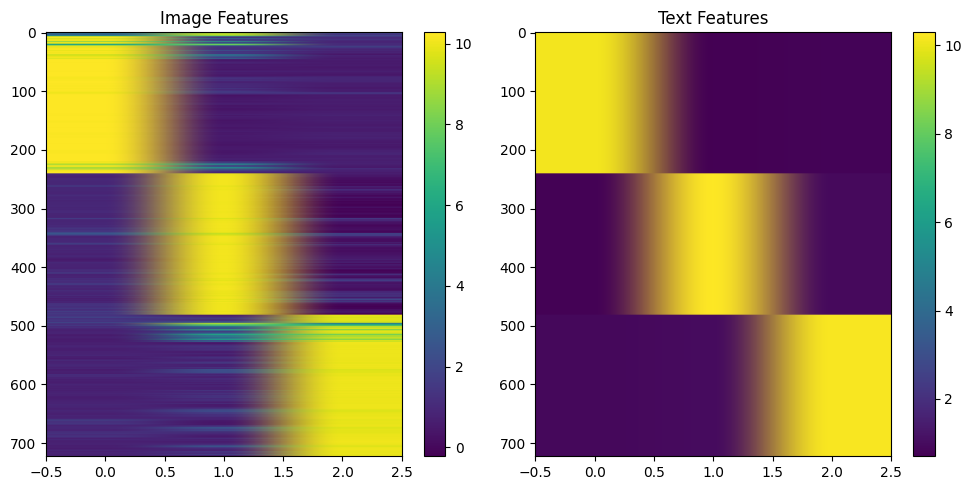

In [20]:
# 内部测试集
i, t = get_imgfeature_txtfeature(test_dataloader1)
visualize_imgfeature_txtfeature(i, t)

torch.Size([303, 3, 512])
torch.Size([303, 3, 512])
torch.Size([303, 3, 512]) torch.Size([303, 3, 512])


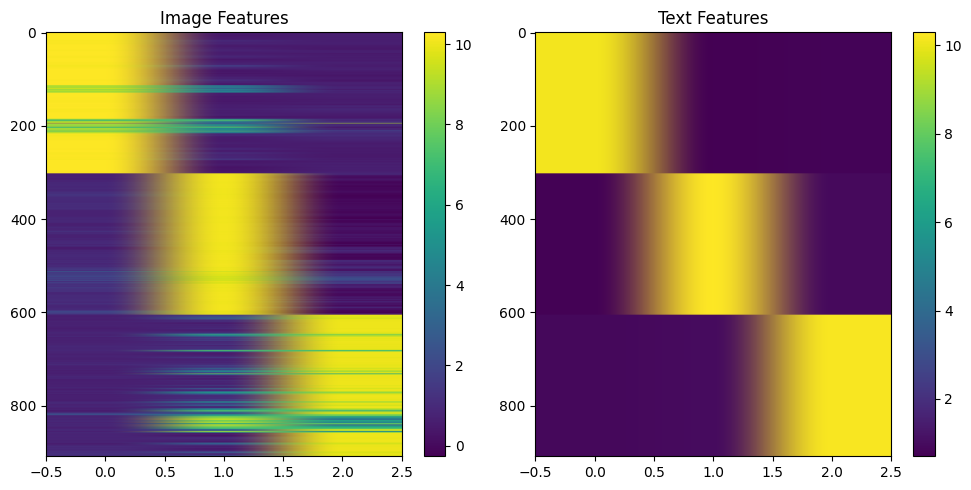

In [20]:
# 外部测试集1
i, t = get_imgfeature_txtfeature(test_dataloader2)
visualize_imgfeature_txtfeature(i, t)

torch.Size([215, 3, 512])
torch.Size([215, 3, 512])
torch.Size([215, 3, 512]) torch.Size([215, 3, 512])


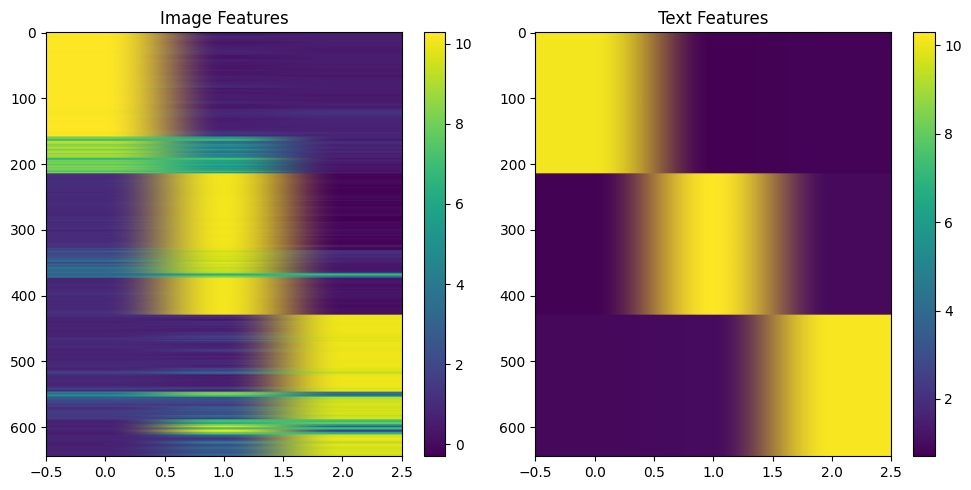

In [12]:
# 外部测试集2
i, t = get_imgfeature_txtfeature(test_dataloader3)
visualize_imgfeature_txtfeature(i, t)